In [2]:
from sklearn.datasets import make_regression
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as LGBM
import pandas as pd

X, y = make_regression(n_samples=10000,
                n_features=1,
                n_informative=1,
                n_targets=1,
                random_state=42)

Xs = pd.DataFrame(X, columns = ['distance'])
ys = pd.DataFrame(y, columns = ['time_to_buyer'])

Xs['distance'] = Xs['distance'].apply(lambda x: 10 + 2 * (x + np.random.normal(loc=1))  )
ys['time_to_buyer'] = ys['time_to_buyer'].apply(lambda x: 60 + 0.3* (x + np.random.normal(loc=1)) )

In [3]:
df = Xs.merge(ys, left_index=True, right_index=True)

In [8]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.10, shuffle=False)
X_train, y_train = train_df[["distance"]], train_df[["time_to_buyer"]]
X_test, y_test = test_df[["distance"]], test_df[["time_to_buyer"]]



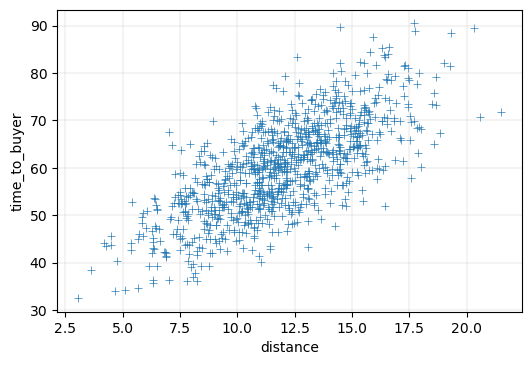

In [9]:
plt.rcParams.update({'font.size': 10, 'figure.dpi': 100})
sns.scatterplot(data=test_df, x='distance', y='time_to_buyer', marker='+')
plt.grid(linestyle='-', linewidth=0.2)

In [10]:
classifiers = {}
for tau in [0.1, 0.5, 0.9]:
    clf = LGBM.LGBMRegressor(objective="quantile", alpha=tau)
    clf.fit(X_train, y_train)
    classifiers[str(tau)] = {'clf': clf,
                             'predictions': pd.DataFrame(clf.predict(X_test), columns=[str(tau)] )}

In [13]:
data = pd.DataFrame({'distance': X_test.reset_index()['distance'],
                     '0.1': classifiers['0.1']['predictions']['0.1'],
                     '0.5': classifiers['0.5']['predictions']['0.5'],
                     '0.9': classifiers['0.9']['predictions']['0.9'],
                     'time_to_buyer': y_test.reset_index()['time_to_buyer']})
data.head()

,distance,0.1,0.5,0.9,time_to_buyer
0,13.624683,56.176355,62.762919,72.019403,62.591560
1,15.266635,60.100989,68.740813,80.703593,58.488578
2,7.502263,42.227380,49.556123,57.933547,54.252045
3,10.781778,46.513211,58.697892,65.730776,56.425497
4,15.208158,60.100989,69.013427,76.312900,63.204070


In [14]:
melt = pd.melt(data, id_vars=['distance'])
melt.head

<bound method NDFrame.head of        distance       variable      value
0     13.624683            0.1  56.176355
1     15.266635            0.1  60.100989
2      7.502263            0.1  42.227380
3     10.781778            0.1  46.513211
4     15.208158            0.1  60.100989
...         ...            ...        ...
3995  11.694452  time_to_buyer  62.753631
3996  11.426157  time_to_buyer  59.832244
3997  15.335555  time_to_buyer  76.156352
3998  11.065257  time_to_buyer  53.576638
3999  15.342279  time_to_buyer  82.291662

[4000 rows x 3 columns]>

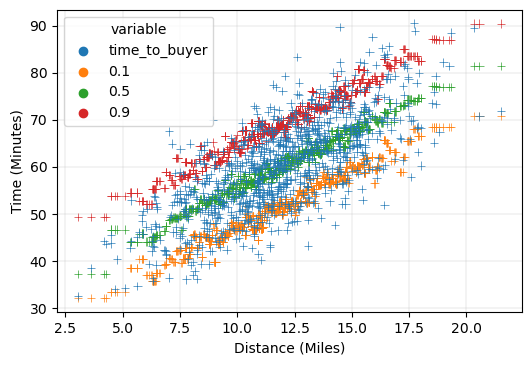

In [15]:
plt.rcParams.update({'font.size': 10, 'figure.dpi':100})
sns.scatterplot(data=melt,
                x="distance",
                y='value',
                hue='variable',
                hue_order=['time_to_buyer', '0.1', '0.5', '0.9'],
                marker='+')
plt.grid(linestyle='-', linewidth=0.2)
ylabel = plt.ylabel("Time (Minutes)")
xlabel = plt.xlabel("Distance (Miles)")